In [756]:
import os
import sys
import numpy as np
import pandas as pd
import subprocess
import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D

import itertools
from susipop import filter
from susipop import reader
from IPython.html.widgets import FloatProgress
from IPython.display import display
from ipywidgets import interactive
import ipywidgets as widgets
%matplotlib notebook

import plotly
import susipop as sp

from multiprocessing import Pool
from scipy.interpolate import griddata

import inspect
from tqdm import *
from termcolor import colored

def get_folder_list():
    f = next(os.walk('.'))[1]
    return f

#  rdf frictional particles at a time

In [726]:

def rdf(path_add,phival, shearrate, bins,time):
    path = path_add+"/rhor1_phi"+str(phival)+"_yd"+str(float(shearrate))+"/"
    dataset = sp.reader.DataSet(path,particles=True, fluid=False)
    print "available timesteps =", len(dataset.tlist)

    
#         print t 
#         print path
    dataset.load_state(dataset.tlist[time])
    idx = np.where(np.array([np.linalg.norm(i) for i in dataset.particles.sshear_fric]) != 0)[0]
    positions = dataset.particles.r[idx]
#         fluid_velocity = dataset.fluid.u
    L = dataset.L # Domain size
    LEs = dataset.LEs  # Lees-Edwards shift at time dataset.t
    LEu = dataset.LEu  # Lees-Edwards velocity

    sim_chars = sp.susi.extract_sim_characteristics(dataset)
    sim_chars['histogram'] = {'bins': bins, 'range': (0, 2.8376564979553224e-05)}
    sim_chars['ball_pid'] = sim_chars['ball_pid']
    sim_chars['radius'] = sim_chars['radius'][idx]
    _, distances = sp.particles.create_particle_particle_distances(positions, **sim_chars)
    sim_chars['distances'] = distances

    rdf = sp.spatial.radial_distribution_function(positions,**sim_chars)
    plt.figure(figsize=[5,5])
    plt.plot(rdf[0]/(2*np.min(sim_chars['radius'])),rdf[1],"g",label="rdf")
    plt.bar(rdf[0]/np.min(2*np.min(sim_chars['radius'])),rdf[1],width = 1.0/sim_chars['histogram']['bins'])


    # s = sim_chars['radius'].min()
    # b = sim_chars['radius'].max()

    s = 4
    b = 11.2/2
    import inspect, re

    def plot_vline(loc, text):
        plt.axvline(loc/float(2*s),linewidth=1,color="k")
        plt.text(loc/float(2*s),3,text, ha = 'right',rotation=90,fontsize=14)

    plot_vline(s+s,"s+s")
    plot_vline(s+b,"s+b")
    plot_vline(b+b,"b+b")

    # plot_vline(s+s+s,"s+s+s")
    # plot_vline(s+s+b,"s+s+b")
    # plot_vline(s+b+b,"s+b+b")
    # plot_vline(b+b+b,"b+b+b")

    # plot_vline(s+s+s+s,"s+s+s+s")
    # plot_vline(s+s+s+b,"s+s+s+b")
    # plot_vline(s+s+b+b,"s+s+b+b")
    # plot_vline(s+b+b+b,"s+b+b+b")
    # plot_vline(b+b+b+b,"b+b+b+b")

    plt.legend(prop={'size':16})
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    plt.text(1.85, 2.7, "s = small particle \nb = big particle \nvertical lines represent the expected \npeaks in RDF due to intersection of \nthe particles"
             , fontsize=14, verticalalignment='top', bbox=props, wrap=True)
    plt.xlabel("2Rmin",fontsize=14)
    plt.ylabel("g(r)")
    plt.xticks(fontsize=10)
#     plt.title(path)
    #plt.savefig("radial_distribution_function")


v = interactive(rdf, \
                 path_add = widgets.Text(value="./phase_separated_flow/F_CL_2e-10_ratio_10.0"),
                phival = widgets.ToggleButtons(options=[40,45,50,54,55,56,58],value=56,disabled=False), \
                shearrate= widgets.ToggleButtons(options=[1,10,11,11.5,12,12.5,13,14,15,16,18,20,30,50,70,100,200,300,1000],value = 12),\
                bins=(10,100),
                time = widgets.IntSlider(max = -1, min = -10000, value = -10),__manual=True)

display(v)

In [727]:
# path = "rhor1_phi56_yd10.0/"
# dataset = sp.reader.DataSet(path,particles=True, fluid=True)
# dataset.load_state(dataset.tlist[-10])
# positions = dataset.particles.r
# idx = np.where(dataset.particles.sshear_fric == 0)[0]
# sim_chars = sp.susi.extract_sim_characteristics(dataset)
# _, distances = sp.particles.create_particle_particle_distances(positions, **sim_chars)
# len(distances), len(idx)

# hist_kwdict = {}
# hist_kwdict.update(sim_chars.get('histogram', dict()))
# if ("range" not in hist_kwdict) and (L is not None):
#     hist_kwdict['range'] = (0, np.max(sim_chars['L']))

# radial_df, bin_edges = np.histogram(distances, **hist_kwdict)
# count2 = []
# loc2 = []
# for i in range(len(count2)):
#     area = 2*3.14*0.5*(loc[i]+loc[i+1])*2*min(sim_chars['radius'])
#     count2.append(count2[i]/area)
#     loc2.append(0.5*(loc[i]+loc[i+1]))
# # plt.figure()

# average rdf frictional particles over time

In [728]:
progress_ = widgets.FloatProgress(min=0,max=100,value=0)
display(progress_)
def rdf(path_add,phival, shearrate, bins,time):
    path = path_add+"/rhor1_phi"+str(phival)+"_yd"+str(float(shearrate))+"/"
    dataset = sp.reader.DataSet(path,particles=True, fluid=False)
    print "available timesteps =", len(dataset.tlist)
    rdf_mean = []
    valid = 0
    for i,t in enumerate(range(time[0], time[1])):
#         try:
        
        progress_.value=float(i)/len(range(time[0], time[1]))*100
#         print t 
#         print path
        dataset.load_state(dataset.tlist[t])
        idx = np.where(np.array([np.linalg.norm(i) for i in dataset.particles.sshear_fric]) != 0)[0]
        if len(idx)>0:
            valid+=1
            positions = dataset.particles.r[idx]
    #         fluid_velocity = dataset.fluid.u
            L = dataset.L # Domain size
            LEs = dataset.LEs  # Lees-Edwards shift at time dataset.t
            LEu = dataset.LEu  # Lees-Edwards velocity

            sim_chars = sp.susi.extract_sim_characteristics(dataset)
            sim_chars['histogram'] = {'bins': bins, 'range': (0, 2.8376564979553224e-05)}
            sim_chars['ball_pid'] = sim_chars['ball_pid']
            sim_chars['radius'] = sim_chars['radius'][idx]
            _, distances = sp.particles.create_particle_particle_distances(positions, **sim_chars)
            sim_chars['distances'] = distances

            rdf = sp.spatial.radial_distribution_function(positions,**sim_chars)
#             print rdf
            if t==time[0]:
    #             print t==time[0]
                rdf_mean = np.asarray(rdf)
            else:
    #             print t==time[0]
                rdf_mean[1] += rdf[1]
        else:
            coninue
#         print np.shape(rdf[0]),np.shape(rdf[1])
#         except:
#             valid-=1
#             continue
    
    rdf_mean = np.asarray(rdf_mean)
#     print rdf_mean
#     print valid
    
    rdf_mean[1] /= float(valid)
#     print rdf[1]-rdf_mean[1]
    plt.figure(figsize=[5,5])
    plt.plot(rdf_mean[0]/(2*np.min(sim_chars['radius'])),rdf_mean[1],"g",label="rdf")
    plt.bar(rdf_mean[0]/np.min(2*np.min(sim_chars['radius'])),rdf_mean[1],width = 1.0/sim_chars['histogram']['bins'])


    # s = sim_chars['radius'].min()
    # b = sim_chars['radius'].max()

    s = 4
    b = 11.2/2
    import inspect, re

    def plot_vline(loc, text):
        plt.axvline(loc/float(2*s),linewidth=1,color="k")
        plt.text(loc/float(2*s),3,text, ha = 'right',rotation=90,fontsize=14)

    plot_vline(s+s,"s+s")
    plot_vline(s+b,"s+b")
    plot_vline(b+b,"b+b")

    # plot_vline(s+s+s,"s+s+s")
    # plot_vline(s+s+b,"s+s+b")
    # plot_vline(s+b+b,"s+b+b")
    # plot_vline(b+b+b,"b+b+b")

    # plot_vline(s+s+s+s,"s+s+s+s")
    # plot_vline(s+s+s+b,"s+s+s+b")
    # plot_vline(s+s+b+b,"s+s+b+b")
    # plot_vline(s+b+b+b,"s+b+b+b")
    # plot_vline(b+b+b+b,"b+b+b+b")

    plt.legend(prop={'size':16})
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    plt.text(1.85, 2.7, "s = small particle \nb = big particle \nvertical lines represent the expected \npeaks in RDF due to intersection of \nthe particles"
             , fontsize=14, verticalalignment='top', bbox=props, wrap=True)
    plt.xlabel("2Rmin",fontsize=14)
    plt.ylabel("g(r)")
    plt.ylim([0,7])
    plt.xticks(fontsize=10)
#     plt.title(path)
    #plt.savefig("radial_distribution_function")


v = interactive(rdf, \
                 path_add = widgets.Text(value="./phase_separated_flow/F_CL_2e-10_ratio_10.0"),
                phival = widgets.ToggleButtons(options=[40,45,50,54,55,56,58],value=56,disabled=False), \
                shearrate= widgets.ToggleButtons(options=[1,10,11,11.5,12,12.5,13,14,15,16,18,20,30,50,70,100,200,300,1000],value = 50),\
                bins=(10,100),
                time = widgets.IntRangeSlider(max = -1, min = -10000, value = [-10,-1]),__manual=True)

display(v)

# average rdf all particles over time

available timesteps = 769


<IPython.core.display.Javascript object>


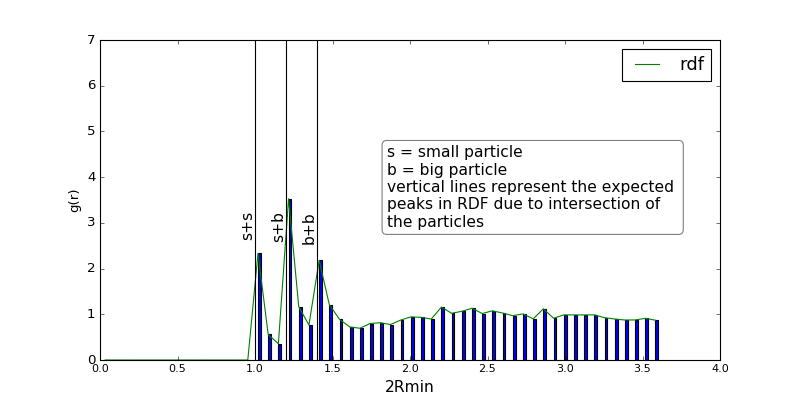

In [740]:
progress_ = widgets.FloatProgress(min=0,max=100,value=0)
display(progress_)
def rdf(path_add,phival, shearrate, bins,time):
    path = path_add+"/rhor1_phi"+str(phival)+"_yd"+str(float(shearrate))+"/"
    dataset = sp.reader.DataSet(path,particles=True, fluid=False)
    print "available timesteps =", len(dataset.tlist)
    rdf_mean = []
    valid = 0
    for i,t in enumerate(range(time[0], time[1])):
#         try:
        
        progress_.value=float(i)/len(range(time[0], time[1]))*100
#         print t 
#         print path
        dataset.load_state(dataset.tlist[t])
#         if len(idx)>0:
        valid+=1
        positions = dataset.particles.r
#         fluid_velocity = dataset.fluid.u
        L = dataset.L # Domain size
        LEs = dataset.LEs  # Lees-Edwards shift at time dataset.t
        LEu = dataset.LEu  # Lees-Edwards velocity

        sim_chars = sp.susi.extract_sim_characteristics(dataset)
        sim_chars['histogram'] = {'bins': bins, 'range': (0, 2.8376564979553224e-05)}
        sim_chars['ball_pid'] = sim_chars['ball_pid']
        sim_chars['radius'] = sim_chars['radius']
        _, distances = sp.particles.create_particle_particle_distances(positions, **sim_chars)
        sim_chars['distances'] = distances

        rdf = sp.spatial.radial_distribution_function(positions,**sim_chars)
#             print rdf
        if t==time[0]:
#             print t==time[0]
            rdf_mean = np.asarray(rdf)
        else:
#             print t==time[0]
            rdf_mean[1] += rdf[1]
#         else:
#             coninue
#         print np.shape(rdf[0]),np.shape(rdf[1])
#         except:
#             valid-=1
#             continue
    
    rdf_mean = np.asarray(rdf_mean)
#     print rdf_mean
#     print valid
    
    rdf_mean[1] /= float(valid)
#     print rdf[1]-rdf_mean[1]
    plt.figure(figsize=[10,5])
    plt.plot(rdf_mean[0]/(2*np.min(sim_chars['radius'])),rdf_mean[1],"g",label="rdf")
    plt.bar(rdf_mean[0]/np.min(2*np.min(sim_chars['radius'])),rdf_mean[1],width = 1.0/sim_chars['histogram']['bins'])


    # s = sim_chars['radius'].min()
    # b = sim_chars['radius'].max()

    s = 4
    b = 11.2/2
    import inspect, re

    def plot_vline(loc, text):
        plt.axvline(loc/float(2*s),linewidth=1,color="k")
        plt.text(loc/float(2*s),3,text, ha = 'right',rotation=90,fontsize=14)

    plot_vline(s+s,"s+s")
    plot_vline(s+b,"s+b")
    plot_vline(b+b,"b+b")

    # plot_vline(s+s+s,"s+s+s")
    # plot_vline(s+s+b,"s+s+b")
    # plot_vline(s+b+b,"s+b+b")
    # plot_vline(b+b+b,"b+b+b")

    # plot_vline(s+s+s+s,"s+s+s+s")
    # plot_vline(s+s+s+b,"s+s+s+b")
    # plot_vline(s+s+b+b,"s+s+b+b")
    # plot_vline(s+b+b+b,"s+b+b+b")
    # plot_vline(b+b+b+b,"b+b+b+b")

    plt.legend(prop={'size':16})
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    plt.text(1.85, 4.7, "s = small particle \nb = big particle \nvertical lines represent the expected \npeaks in RDF due to intersection of \nthe particles"
             , fontsize=14, verticalalignment='top', bbox=props, wrap=True)
    plt.xlabel("2Rmin",fontsize=14)
    plt.ylabel("g(r)")
    plt.ylim([0,7])
    plt.xticks(fontsize=10)
#     plt.title(path)
    #plt.savefig("radial_distribution_function")


v = interactive(rdf, \
                 path_add = widgets.Text(value="."),
                phival = widgets.ToggleButtons(options=[40,45,50,54,55,56,58],value=56,disabled=False), \
                shearrate= widgets.ToggleButtons(options=[1,10,11,11.5,12,12.5,13,14,15,16,18,20,30,50,70,100,200,300,1000],value = 50),\
                bins=(10,100),
                time = widgets.IntRangeSlider(max = -1, min = -10000, value = [-10,-1]),__manual=True)

display(v)

In [730]:
#phase separated flow veolocity differences

In [731]:
# # plt.figure()
# for i,ratio in enumerate(["10.0","100.0","1000.0"]):
#     velup_mean = [[],[],[]]
#     veldown_mean =  [[],[],[]]
#     time_ =  [[],[],[]]
#     path = "./phase_separated_flow/F_CL_2e-10_ratio_"+ratio+"/rhor1_phi56_yd50.0/"
#     dataset = sp.reader.DataSet(path,particles=True, fluid=False)
#     for t in range(100,600):
#         dataset.load_state(dataset.tlist[t])
#         mid = 3.2e-5
#         idxup = np.where(dataset.particles.r[:,2] > mid)[0]
#         idxdown = np.where(dataset.particles.r[:,2] <= mid)[0]
#         velup = np.mean(np.linalg.norm(dataset.particles.newton_velocity[idxup]))
#         veldown = np.mean(np.linalg.norm(dataset.particles.newton_velocity[idxdown]))
#         velup_mean[i].append(velup)
#         veldown_mean[i].append(veldown)
#         time_[i].append(dataset.tlist[t])
#     print ratio, np.mean(veldown_mean[i])/np.mean(velup_mean[i])
# #     plt.title("phi=56,yd=50,fcl ratio="+ratio)
# #     plt.plot(time_[i],veldown_mean[i],label = "frictional regime fcl="+ratio)
# #     plt.plot(time_[i],velup_mean[i],label = "non frictional regime fcl="+ratio)
# #     plt.plot(time_[i][:len(velup_mean)],[veldown_mean[i][j]/velup_mean[i][j] for j in range(len(velup_mean))],label = "non-frictional to frictional regime velocity ratio fcl="+ratio)
# # plt.legend()

In [732]:
# def gen(p):
#         return np.random.choice([0, 1], size=1, p=[1-p, p])[0]
# def disp_cells(m,phival,fraction_in_friction):    
#     plt.figure()
#     p = phival*fraction_in_friction 
#     domain = np.zeros((m,m))
#     for i in range(m):
#         for j in range(m):
#             domain[i,j] = gen(p)
#     plt.imshow(domain,interpolation='nearest')

# v = interactive(disp_cells, \
#     m = widgets.IntText(min = 10, max = 1000, value = 100),
#     phival = widgets.FloatSlider(max = 1, min = 0, value = 0.5),
#     fraction_in_friction=widgets.FloatSlider(max = 1, min = 0, value = 0.5) 
#     ,__manual=False)

# display(v)

In [733]:
# plt.figure()
# import networkx as nx

# x = range(10)
# Xi,Yi=np.meshgrid(x,x)
# Xi,Yi = Xi.flatten(),Yi.flatten()
# pos = dict()
# for i in range(len(Xi)):
#     pos[i] = (Xi[i],Yi[i])
# X=nx.Graph()
# X.add_nodes_from(pos.keys())


# # for i in range(20):
# #     X.add_edge(random.randint(1,100),random.randint(1,100))
# #     X.remove_node(i)
# #     print X.neighbors(i+50)
    
# nx.draw(X, pos, node_size=10)
# plt.show()

In [734]:
# plt.figure()
# import scipy.spatial as spatial
# x = range(10)
# x,y=np.mgrid[0:10, 0:10]
# pts = zip(x.ravel(), y.ravel())
# pos = dict()
# for i,val in enumerate(pts):
#     pos[i] = val

# G=nx.Graph()
# G.add_nodes_from(pos.keys())

# points = np.random.random(100).reshape(2,50)
# combined_x_y_arrays = np.dstack([x.ravel(),x.ravel()])[0]
# points_list = list(points.transpose())


# def do_kdtree(combined_x_y_arrays,points):
#     mytree = spatial.cKDTree(combined_x_y_arrays)
#     dist, indexes = mytree.query(points)
#     return indexes

# do_kdtree(combined_x_y_arrays,points_list)



# spatial autocorrelation functions

In [735]:
from scipy import spatial

# path = path_add+"/rhor1_phi"+str(phival)+"_yd"+str(float(shearrate))+"/"
# dataset = sp.reader.DataSet(path,particles=True, fluid=False)
class spatial_autocorrelations:
    def __init__(self, phi, yd):
        self.path =  "rhor1_phi"+str(phi)+"_yd"+str(float(yd))+"/"
        self.dataset = sp.reader.DataSet(self.path, particles = True, fluid=False)
        
    def load_state(self,t):
        # t ranges from 1 - inf --> timesteps in the simulation
        self.dataset.load_state(self.dataset.tlist[t])
        self.points = dataset.particles.r
        self.get_kd_tree()
        self.get_viscosity()
        
    def get_kd_tree(self):
        self.kdtree =  spatial.KDTree(self.points)
        
    def get_nearest_points_distances_list(self,cutoff=1e-7,num_of_nearest_neighbours=4):
        #returns the point and its neighbours
        #if num_of_nearest_neighbours == None:
        #    self.nearest_neighbours = self.kdtree.query_ball_tree(self.kdtree,cutoff)
        #    return self.nearest_neighbours
        #else:
        distances_neigbors = self.kdtree.query(self.points, k=num_of_nearest_neighbours+1)
        self.nearest_neighbours = distances_neigbors[1]
        self.nearest_neighbours_distances = distances_neigbors[0]
        
    def get_interparticle_gap(self,idx1,idx2):
        radius1 = self.dataset.particles.radius[idx1]
        radius2 = self.dataset.particles.radius[idx2]
        distance = np.linalg.norm(self.points[idx1] - self.points[idx2])
        gap = distance - (radius1+radius2)
        return gap
    def get_viscosity(self):
        visc_path = self.path + "/result/nu_t.dat"
        visc = pd.read_csv(visc_path)
        self.nu = np.asarray(visc[visc.columns[2]])
        self.nu_rel = np.asarray(visc[visc.columns[4]])
        
    def calc_moran(self,yval,neighbours = 3):
        #reutrns morans I, use M.I to get value from sim 
        wnn = pysal.knnW_from_array(self.points, neighbours)
        wnn.transform = 'r'
#         yval = [np.linalg.norm(i) for i in obj.dataset.particles.force_fric]
        M = pysal.Moran(yval, wnn, two_tailed=False)
        return M
    def calc_geary(self,yval,neighbours = 3):
        #reutrns morans I, use M.I to get value from sim 
        wnn = pysal.knnW_from_array(self.points, neighbours)
        wnn.transform = 'r'
#         yval = [np.linalg.norm(i) for i in obj.dataset.particles.force_fric]
        G = pysal.Geary(yval, wnn)
        return G
        
        

In [753]:
obj = spatial_autocorrelations(phi=56,yd=70.0)
obj.dataset
M_list = []
G_list = []
nu_list = []
for t in trange(1,len(obj.dataset.tlist)):
    try:
        obj.load_state(t)
        # obj.get_nearest_points_distances_list(cutoff=9.7e-6,num_of_nearest_neighbours=4)
        M = obj.calc_moran([np.linalg.norm(i) for i in obj.dataset.particles.force_fric],4)
        G = obj.calc_geary([np.linalg.norm(i) for i in obj.dataset.particles.force_fric],4)
        M_list.append(M)
        G_list.append(G)
        nu_list.append(obj.nu[t-1])
    except Exception as e:
#         print e
        continue

100%|██████████| 454/454 [09:14<00:00,  1.30s/it]


-0.019603155309149051

In [754]:
nu_list = np.asanyarray(nu_list)
MI = np.asanyarray([m.I for m in M_list[1:]]) 
MI_z = np.asanyarray([m.z_norm for m in M_list[1:]]) 
MI_p_sim = np.asanyarray([m.p_sim for m in M_list[2:]]) 
MI_p_norm = np.asanyarray([m.p_norm for m in M_list[2:]]) 
steps = np.arange(len(MI))

G = np.asanyarray([g.C for g in G_list[2:]])
G_p_sim = np.asanyarray([g.p_sim for g in G_list[2:]])

# print G_p_sim
plt.figure(figsize=[13,10])
plt.subplot(321)
idx = np.where(MI_p_sim <= 0.05)[0]
plt.plot(steps[idx], MI[idx],label = "Moran's I")
plt.plot(steps[idx], MI_p_sim[idx], label = "p_sim")
plt.plot(steps[idx], nu_list[idx], label = "viscosity")
plt.yscale('symlog')
plt.xlabel("steps")
plt.ylabel("viscosity and moran's I")
plt.legend(loc= "best")

plt.subplot(322)
idx = np.where(G_p_sim <= 0.05)[0]

plt.plot(steps[idx], G[idx] , label= "normalized G")
plt.plot(steps[idx], G_p_sim[idx], label = "p_sim")
plt.plot(steps[idx], nu_list[idx], label = "normalized viscosity")
plt.yscale('symlog')
plt.xlabel("steps")
plt.ylabel("viscosity and grary's C")
plt.suptitle(obj.dataset.dir)
plt.legend(loc= "best")

plt.subplot(323)
idx = np.where(MI_p_sim >= 0.05)[0]
plt.plot(steps[idx], MI[idx],label = "Moran's I")
plt.plot(steps[idx], MI_p_sim[idx], label = "p_sim")
plt.plot(steps[idx], nu_list[idx], label = "viscosity")
plt.yscale('symlog')
plt.xlabel("steps")
plt.ylabel("viscosity and moran's I")
plt.legend(loc= "best")

plt.subplot(324)
idx = np.where(G_p_sim >= 0.05)[0]

plt.plot(steps[idx], G[idx] , label= "normalized G")
plt.plot(steps[idx], G_p_sim[idx], label = "p_sim")
plt.plot(steps[idx], nu_list[idx], label = "normalized viscosity")
plt.yscale('symlog')
plt.xlabel("steps")
plt.ylabel("viscosity and grary's C")
plt.suptitle(obj.dataset.dir)
plt.legend(loc= "best")

plt.subplot(325)
idx = np.where(MI_p_sim <= 0.05)[0]
plt.plot(steps, MI,label = "Moran's I")
plt.plot(steps, MI_p_sim, label = "p_sim")
plt.plot(steps, nu_list, label = "viscosity")
plt.yscale('symlog')
plt.xlabel("steps")
plt.ylabel("viscosity and moran's I")
plt.legend(loc= "best")

plt.subplot(326)
idx = np.where(G_p_sim <= 0.05)[0]

plt.plot(steps, G , label= "normalized G")
plt.plot(steps, G_p_sim, label = "p_sim")
plt.plot(steps, nu_list, label = "normalized viscosity")
plt.yscale('symlog')
plt.xlabel("steps")
plt.ylabel("viscosity and grary's C")
plt.suptitle(obj.dataset.dir)
plt.legend(loc= "best")

# plt.plot(MI_p_norm, label = "p_norm")
# plt.axhline(0.05,color='k')
# plt.axhline(-3,color='k')

# plt.plot([m/max(MI) for m in MI], label = "normalized Moran's I")
# plt.plot([i/float(max(nu_list)) for i in np.asarray(nu_list)], label = "normalized viscosity")
# plt.plot([zn for zn in MI_z], label = "Z")

# for i in range(2,len(MI)):
#     obj.load_state(i)
#     val = obj.calc_moran(np.linalg.norm(obj.dataset.particles.sshear_fric,axis=1)).p_norm
#     if np.abs(val) < 0.05:
#         print colored(val, 'green'), obj.nu_rel[i-1]
#     else:
#         print colored(val, 'red'), obj.nu_rel[i-1]
        

<IPython.core.display.Javascript object>

IndexError: index 443 is out of bounds for axis 1 with size 442

# Testing the gaps and force calculation

In [959]:
def get_gaps_get_nfric(exp,t,mingap):
    exp.load_state(exp.tlist[t])
    r = exp.particles.r
    rad = exp.particles.radius
    gaps = []
    for i,r1 in enumerate(r):
        for j,r2 in enumerate(r):
            if i!=j:
                gap_ij= np.linalg.norm(r1-r2) - rad[i] - rad[j]
                gaps.append([i,j,gap_ij])
    gaps = np.array(gaps).T
    idx = np.where(gaps[2]<=mingap)[0]
    valid_gaps = gaps[2][idx]
    valid_i = gaps[0][idx]
    valid_j = gaps[1][idx]
    return r,rad,valid_i, valid_j, valid_gaps
def is_frictional(i):
    try:
        return [np.linalg.norm(exp.particles.force_fric[idx]) != 0 for idx in i], [np.linalg.norm(exp.particles.force_rep[idx]) for idx in i]
    except:
        return [np.linalg.norm(exp.particles.force_fric[i])!= 0], [np.linalg.norm(exp.particles.force_rep[i])]
t = -1
exp = reader.DataSet("rhor1_phi56_yd10.0/",particles = True);exp.load_state(exp.tlist[t])

In [974]:
# number of frictional particles in the system based on frictional force
idx_fric = np.unique(np.where(np.array(map(np.linalg.norm, exp.particles.force_fric))!=0)[0])
n_fric = len(idx_fric)
print n_fric

90


In [981]:
#number of frictional particles based on cluster gaps 
g = 6.515e-8
r,rad,idx_i, idx_j, valid_gaps= get_gaps_get_nfric(exp,t,g)
n_fric_from_gap = len(np.unique(idx_i))
print n_fric_from_gap

90


In [972]:
# kd tree to look at the nearest neighbor distance of the particles
from scipy import spatial
tree = spatial.KDTree(r)
query_idx =50
print "queried idx:\t\t\t{}".format(query_idx), "\nis frictional:{0}, Force:{1}:\t",is_frictional(query_idx)

dist_kd, idx = tree.query(r[query_idx],k=5)
gaps_kd = dist_kd - (rad[idx] + rad[query_idx]*np.ones_like(dist_kd))

print "gaps, neighbors:\t\t",  zip([float('{:.1e}'.format(float(i))) for i in gaps_kd],idx)
print "frictional neibrs, rep forces: \t", is_frictional(idx)[0],"\n\t\t\t\t",[float('{:.1e}'.format(float(i))) for i in  is_frictional(idx)[1]]

queried idx:			50 
is frictional:{0}, Force:{1}:	([False], [6.9351299744938017e-11])
gaps, neighbors:		[(-1.1e-05, 50), (3.9e-07, 60), (1.2e-06, 121), (1.7e-06, 152), (7.7e-08, 77)]
frictional neibrs, rep forces: 	[False, False, False, True, False] 
				[6.9e-11, 5.1e-11, 2e-11, 1e-10, 3.6e-11]


In [971]:
idx_fric = np.unique(np.where(np.array(map(np.linalg.norm, exp.particles.force_fric))!=0)[0])
n_fric = len(idx_fric)
print "n_fric:",n_fric

idx_rep_fric_limit = np.unique(np.where(np.array(map(np.linalg.norm, exp.particles.force_rep))>=1.8e-10)[0])
n_rep_fric_limit = len(idx_rep_fric_limit)
print "n_rep_fric_limit:",n_rep_fric_limit

n_fric: 90
n_rep_fric_limit: 38


([False], [6.9351299744938017e-11])